# BIKE RENT COUNTS PROJECT

# Project Aims and Contents

The dataset contains count of public bicycles rented per hour in the Seoul Bike Sharing System, with corresponding weather data and holiday information. Obtained from https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand. </br>
</br>
The aim of this project is to analyze data correlations within the dataset and attempt to create a linear regression model predicting the expected bike rent count based on the available data.
</br>

# Import Libraries and set up Notebook

In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from functools import partial
from IPython.core.display import display, HTML
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


display(HTML("<style>div.output_scroll { height: 35em; }</style>"))

# Exploratory Data Analysis

## Data discovery

In [242]:
#loading data, inspecting column names and data types;
bikes_df = pd.read_csv('SeoulBikeData.csv')
bikes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date                      8760 non-null   object 
 1   Rented Bike Count         8760 non-null   int64  
 2   Hour                      8760 non-null   int64  
 3   Temperature(C)            8760 non-null   float64
 4   Humidity(%)               8760 non-null   int64  
 5   Wind speed (m/s)          8760 non-null   float64
 6   Visibility (10m)          8760 non-null   int64  
 7   Dew point temperature(C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)   8760 non-null   float64
 9   Rainfall(mm)              8760 non-null   float64
 10  Snowfall (cm)             8760 non-null   float64
 11  Seasons                   8760 non-null   object 
 12  Holiday                   8760 non-null   object 
 13  Functioning Day           8760 non-null   object 
dtypes: float

In [243]:
#showing first 5 rows of data
bikes_df.head()

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


There are no missing values in any of the columns. Some Object data types can be adjusted for easier handling, e.g. "Date" changed into a Datetime object, "Holiday" and "Functioning Day" changed into Boolean after confirming they hold two unique values.

In [244]:
bikes_df['Holiday'].unique()

array(['No Holiday', 'Holiday'], dtype=object)

In [245]:
bikes_df['Functioning Day'].unique()

array(['Yes', 'No'], dtype=object)

In [246]:
#summary of the dataset
bikes_df.describe()

,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


The dataset includes rented bike counts from Dec 1st. 2017 to Nov. 30th 2018. The data is provided for every hour of the day, along with weather information including Temperature, Humidity, Wind Speed and Rainfall. It also describes the Season of the year for every entry and indicates whether it was a holiday or not. The bike renting service was not always available, which is indicated by the Functioning Day column.

The dataset consists of 8760 entries in total. The mean bike count rent is 705 rents per hour, while the median amounts to 505 rents. This difference is most likely linked to outliers with unusually high counts of bike rents. This is further reinforced by checking the min/max values for the rented bike count, which are 0 and 3556 respectively.

The average year temperature amounts to 12.9 degrees Celsius with a median of 13.7.

An interesting observation can be made with Rainfall and Snowfall features - while they have a relatively low mean values (1.1 mm and 0.4 mm respectively), their median values are both at 0. This essentially means that over 50% of the time (measured in hours) there were no rain- or snowfalls.

## Data Cleanup

Since both Holiday and Functioning Day features include only 2 unique values each, turning their data type into boolean will make further data processing more efficient. The Date feature will be turned a proper Datetime type along the way.

In [247]:
#changing Date feature into Datetime
bikes_df['Date'] = pd.to_datetime(bikes_df['Date'], format="%d/%m/%Y")

#changing Holiday feature into Boolean
bikes_df["Holiday"]= bikes_df["Holiday"].map({'No Holiday': 0,'Holiday':1})

#changing Functioning Day feature into Boolean
bikes_df["Functioning Day"]= bikes_df["Functioning Day"].map({"No": 0,"Yes":1})

#removing spacing in column names
bikes_df.rename(inplace=True, columns={'Rented Bike Count':'RentedBikeCount', 'Dew point temperature(C)':'DewPointTemperature(C)','Wind speed (m/s)':'WindSpeed(m/s)','Visibility (10m)':'Visibility(10m)','Solar Radiation (MJ/m2)':'SolarRadiation(MJ/m2)','Snowfall (cm)':'Snowfall(cm)'})

#checking the data types after changes
print(bikes_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    8760 non-null   datetime64[ns]
 1   RentedBikeCount         8760 non-null   int64         
 2   Hour                    8760 non-null   int64         
 3   Temperature(C)          8760 non-null   float64       
 4   Humidity(%)             8760 non-null   int64         
 5   WindSpeed(m/s)          8760 non-null   float64       
 6   Visibility(10m)         8760 non-null   int64         
 7   DewPointTemperature(C)  8760 non-null   float64       
 8   SolarRadiation(MJ/m2)   8760 non-null   float64       
 9   Rainfall(mm)            8760 non-null   float64       
 10  Snowfall(cm)            8760 non-null   float64       
 11  Seasons                 8760 non-null   object        
 12  Holiday                 8760 non-null   int64   

## Data distributions

Plotting histograms, violin and bar plots to get a visual idea of the data distributions for all features except for the Date, Hour, Month, Holiday, Seasons and Functioning Day features.

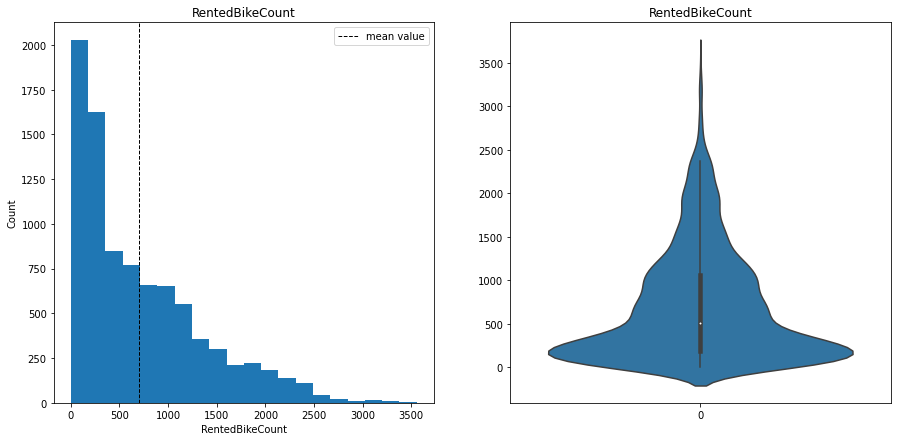

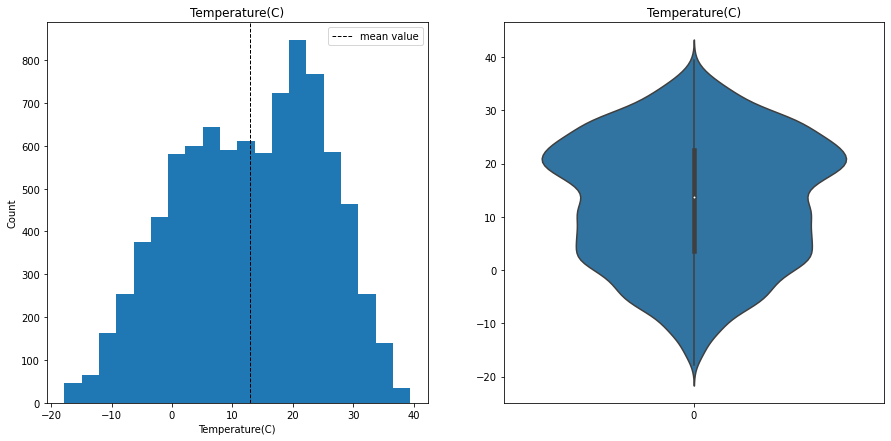

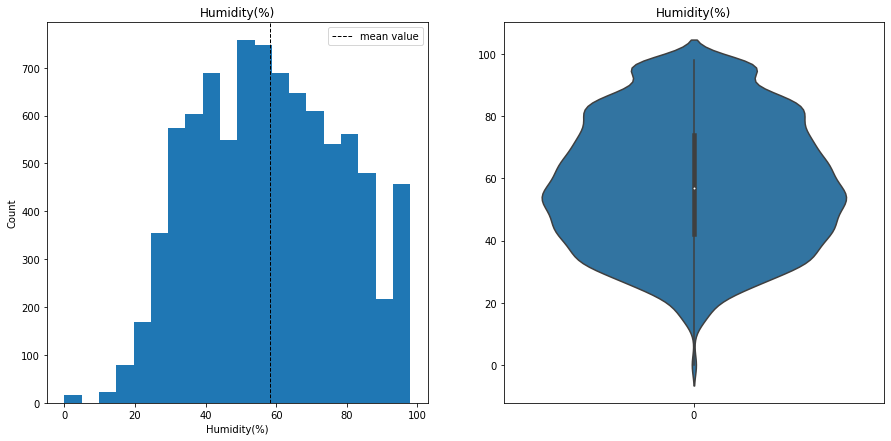

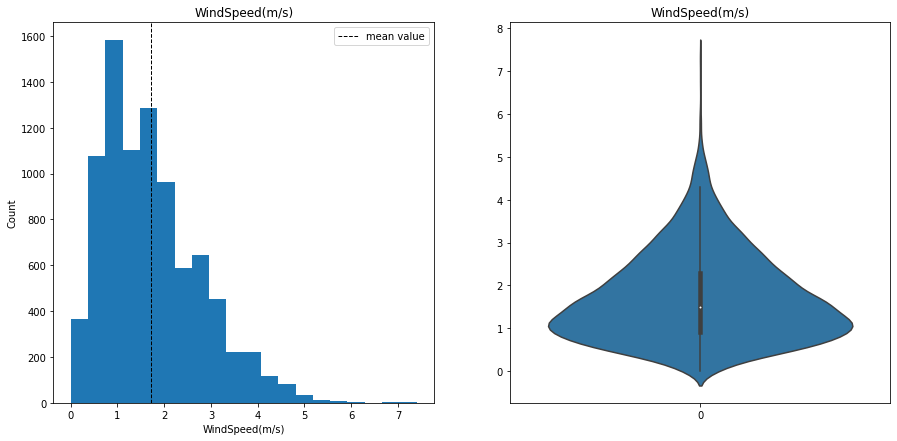

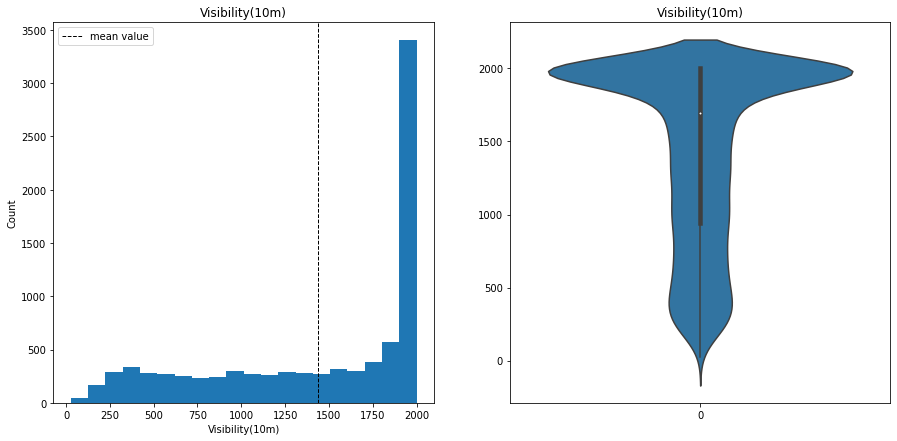

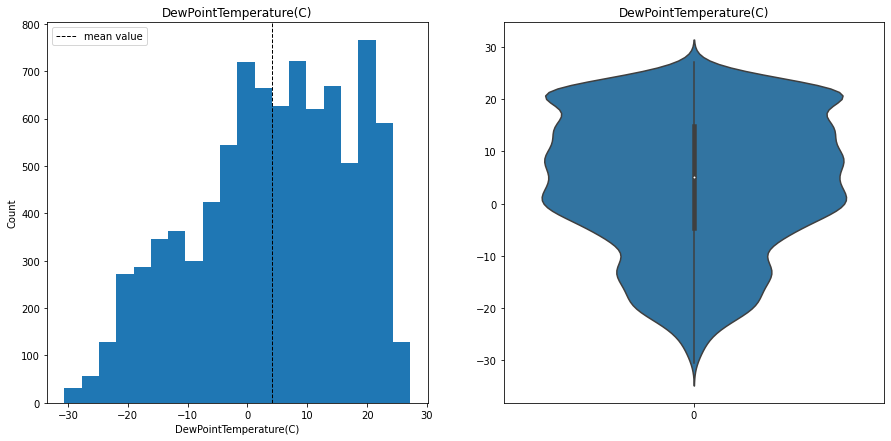

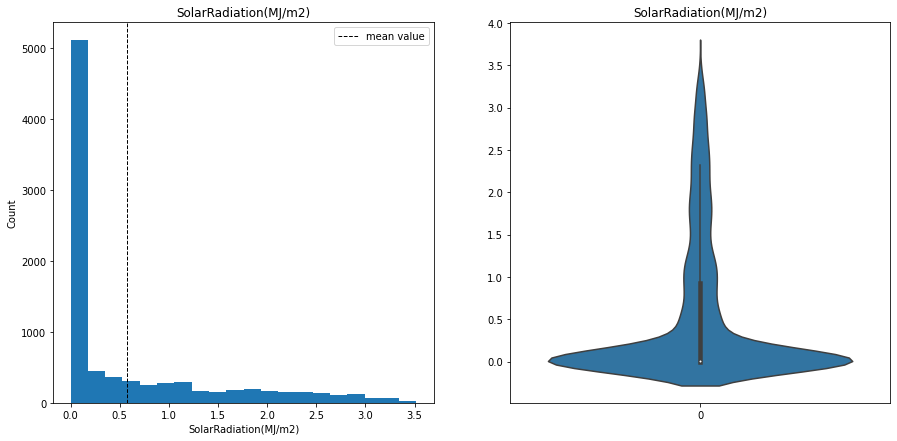

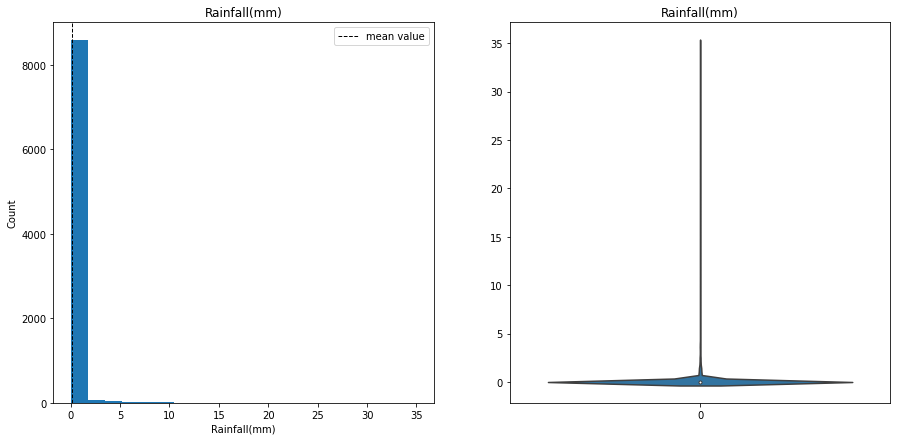

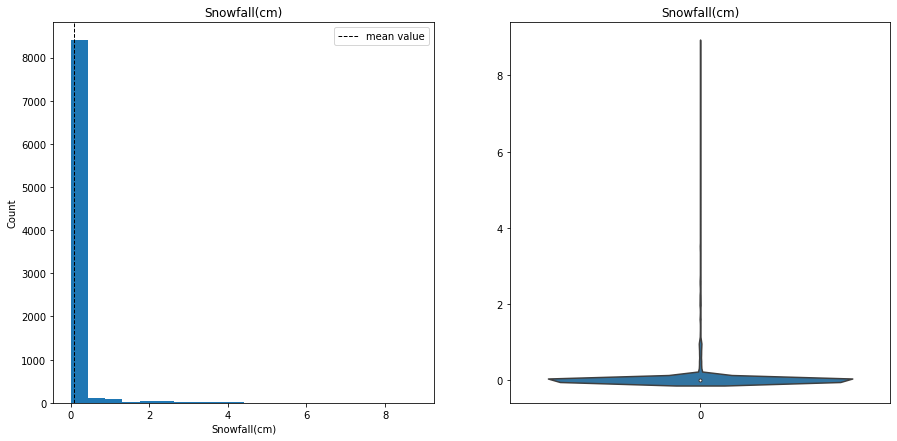

In [248]:
for i in bikes_df.columns:
    if i in ['Date', 'Hour', 'Month', 'Holiday', 'Functioning Day', 'Seasons'] or bikes_df[i].dtype == 'bool':
        continue
    elif bikes_df[i].dtype == 'object':
        grouping = bikes_df.groupby(i).size().reset_index()
        grouping.columns = [i, 'count']
        sns.barplot(data = grouping,  x = i, y = 'count')
        plt.title(i)
        plt.show()
        plt.clf
    else:
        fig, ax = plt.subplots(figsize=(15,7))
        ax = plt.subplot(1,2,1)
        plt.figure
        plt.hist(bikes_df[i], bins=20)
        plt.axvline(bikes_df[i].mean(), color='k', linestyle='dashed', linewidth=1, label='mean value')
        plt.legend()
        plt.title(i)
        plt.xlabel(i)
        plt.ylabel('Count')
        ax = plt.subplot(1,2,2)
        sns.violinplot(data=bikes_df[i])
        plt.title(i)
        plt.show()
        plt.clf

Rented bike count is right skewed and far from a normal distribution, as the values are concentrated around lower numbers of bike rents. The mean bike count rent per hour is around 700, while the median per hour bike rent count is around 500.<br />
Temperature is much closer to a normal distribution, although it is slightly left skewed. The mean temperature amounts to around 13 degrees Celsius, while the median is slightly higher at around 14 degrees. It is worth noting that Dew Point temperature appears to be distributed in a much similar fashion to Temperature, implying a close correlation.<br />
Humidity is normally distributed with mean humidity at 58% and the median at 57%.<br />
Wind speed, rainfall, snowfall and solar radiation are heavily right skewed, which is expected, as the high values can go to large extremes and form a long tail of outliers on the graphs. Similarly to the Visibity feature except that it is heavily left skewed.<br />




The rented bike count histogram presented the data as is, i.e. displayed the counts for every hour throughout the year. Let's agggregate the same data on a per day basis, to get an overview of counts distribution for entire days.

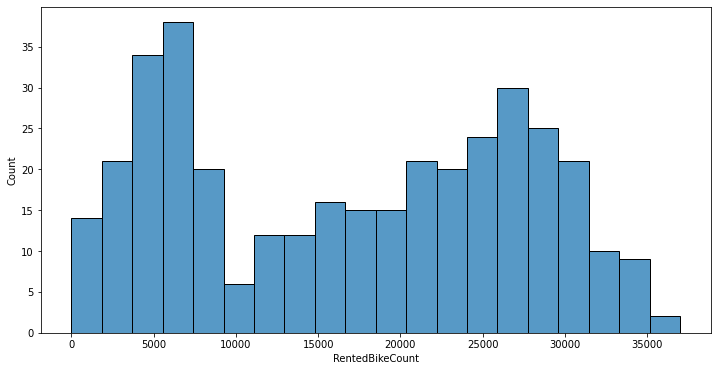

In [249]:
rent_day_group = bikes_df[['Date', 'RentedBikeCount']].groupby(['Date']).sum()
plt.figure(figsize=(12,6))
sns.histplot(data=rent_day_group, x='RentedBikeCount',bins=20, binrange=(0,37000))
plt.show()

The histogram has a significantly different shape then the one created for per hour bike counts. Let's see whether the shape is correlated with bike rent counts for different seasons.

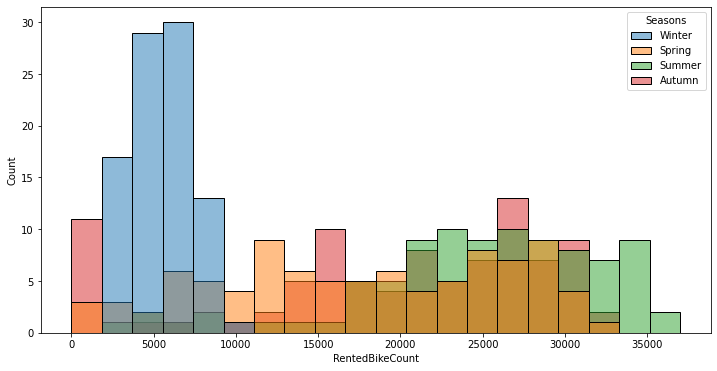

<Figure size 432x288 with 0 Axes>

In [250]:
rent_season_group = bikes_df[['Date', 'Seasons','RentedBikeCount']].groupby(['Date', 'Seasons']).sum()
plt.figure(figsize=(12,6))
sns.histplot(data=rent_season_group, x='RentedBikeCount', hue='Seasons',bins=20,binrange=(0,37000))
plt.show()
plt.clf()


The shape of the histogram changed significantly for most of the bins except for the 0-1000 range which appears largely unchanged. This range is dominated by Winter readings and that is why when doing a distribution per Season, this block is almost the same as for the per day distribution. We should expect the remaining of the year to regain its previous shape, when we treat the remaining seasons (spring, summer and autumn) as one.

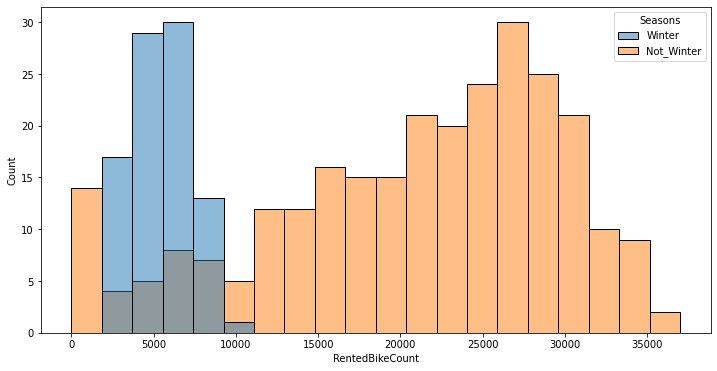

<Figure size 432x288 with 0 Axes>

In [251]:
rent_2season_group = pd.DataFrame(rent_season_group.reset_index())
rent_2season_group.loc[rent_2season_group['Seasons'] != 'Winter', 'Seasons'] = 'Not_Winter'
plt.figure(figsize=(12,6))
sns.histplot(data=rent_2season_group, x='RentedBikeCount', hue='Seasons',bins=20,binrange=(0,37000))
plt.show()
plt.clf()

To understand the data better we might want to exclude the days where the service was not functioning and see the data distribution again:


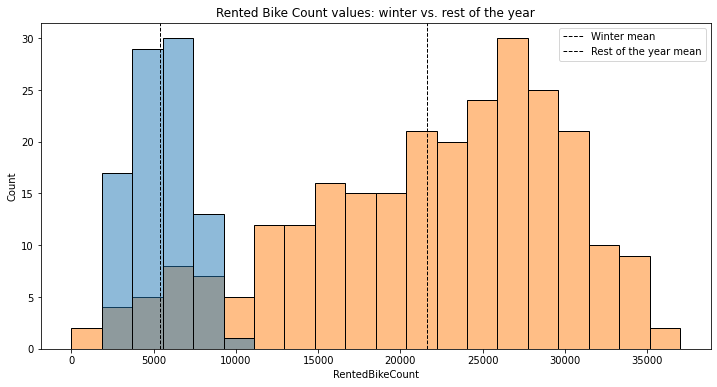

<Figure size 432x288 with 0 Axes>

In [252]:
#Grouping by date and season with only functioning days taken into consideration
bikes_df_only_functioning = bikes_df[bikes_df['Functioning Day'] == True]

rent_season_group_only_functioning = bikes_df_only_functioning[['Date', 'Seasons','RentedBikeCount']].groupby(['Date', 'Seasons']).sum()
rent_season_group_only_functioning = pd.DataFrame(rent_season_group_only_functioning.reset_index())
rent_season_group_only_functioning.loc[rent_season_group_only_functioning['Seasons'] != 'Winter', 'Seasons'] = 'Not_Winter'

plt.figure(figsize=(12,6))
sns.histplot(data=rent_season_group_only_functioning, x='RentedBikeCount', hue='Seasons',bins=20,binrange=(0,37000))
plt.axvline(rent_season_group_only_functioning[rent_season_group_only_functioning['Seasons'] == 'Winter']['RentedBikeCount'].mean(), color='k', linestyle='dashed', linewidth=1, label='Winter mean')
plt.axvline(rent_season_group_only_functioning[rent_season_group_only_functioning['Seasons'] == 'Not_Winter']['RentedBikeCount'].mean(), color='k', linestyle='dashed', linewidth=1, label='Rest of the year mean')
plt.legend()
plt.title('Rented Bike Count values: winter vs. rest of the year')
plt.show()
plt.clf()



The bike rent count distribution is apparently significantly different in Winter than in other months of the year.


## Rented Bike Count Fluctuations Across the Year

To get an overview of the bike renting service, we created a few plots below to demonstrate the trends across different months and their possible link with temperatures and rainfalls.

In [253]:
#creating the "Month" column
bikes_df['Month'] = pd.DatetimeIndex(bikes_df['Date']).month
months_names =['Jan', 'Feb', 'Mar','Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_nums = range(12)
def month_insert(x):
    return months_names[x-1]
bikes_df['Month'] = bikes_df['Month'].apply(month_insert)

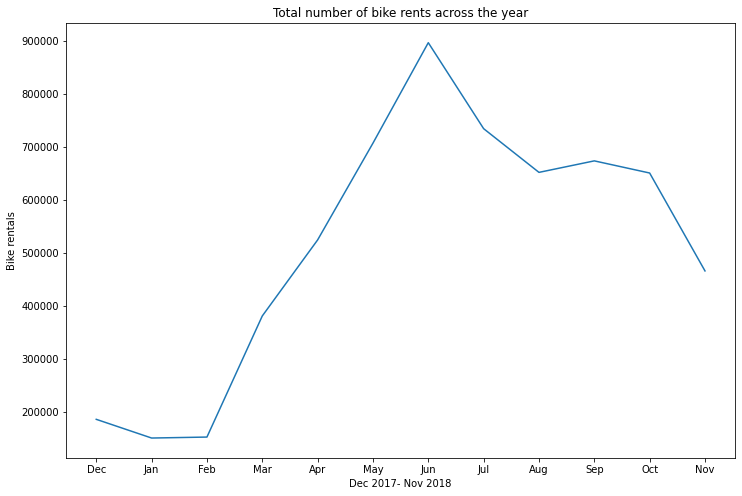

In [254]:
rent_month_group = bikes_df[['Month','RentedBikeCount']].groupby(['Month'], sort=False).sum().reset_index()
plt.figure(figsize=(12,8))
plt.plot(rent_month_group['Month'], rent_month_group['RentedBikeCount'])
plt.xticks(month_nums, labels=([months_names[-1]]+months_names[:-1]))
plt.xlabel('Dec 2017- Nov 2018')
plt.ylabel('Bike rentals')
plt.title('Total number of bike rents across the year')
plt.show()

The total number of bike rents is the lowest in December, January and February and peaks in June. This appears to be slightly correlated by rainfall (note how the rainfall was relatively low in June compared to May and July, August) and closely correlated with the mean month temperature (see plots below).

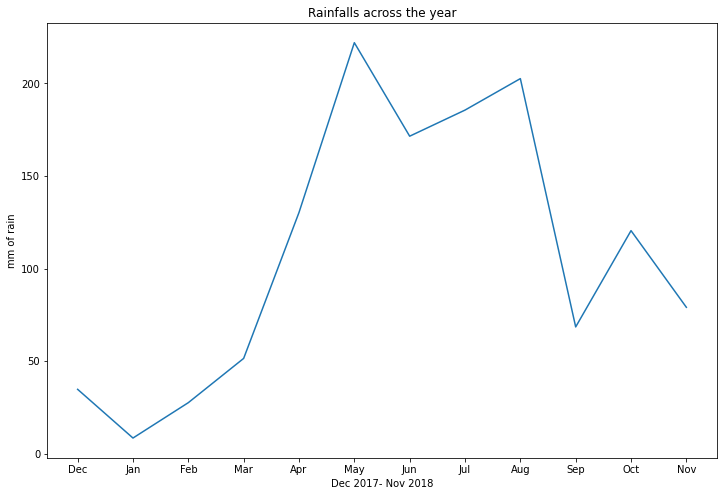

In [255]:
rainfall_month_group = bikes_df[['Month','Rainfall(mm)']].groupby(['Month'], sort=False).sum().reset_index()
plt.figure(figsize=(12,8))
plt.plot(rainfall_month_group['Month'], rainfall_month_group['Rainfall(mm)'])
plt.xticks(month_nums, labels=([months_names[-1]]+months_names[:-1]))
plt.title('Rainfalls across the year')
plt.xlabel('Dec 2017- Nov 2018')
plt.ylabel('mm of rain')
plt.show()


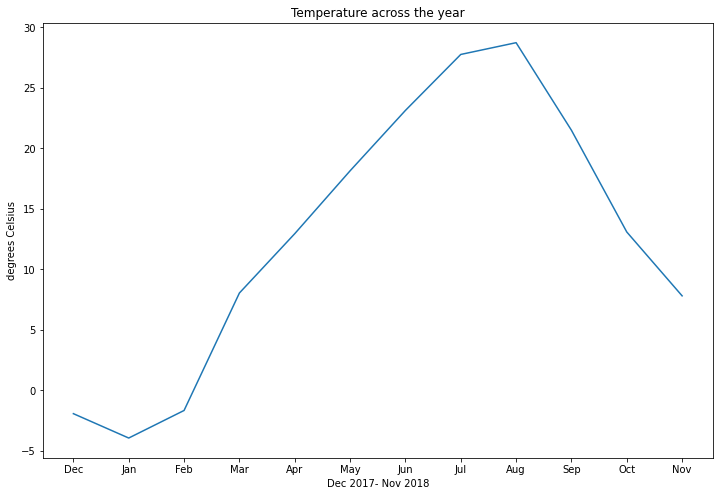

In [256]:
temperature_month_group = bikes_df[['Month','Temperature(C)']].groupby(['Month'],sort=False).mean().reset_index()
plt.figure(figsize=(12,8))
plt.plot(temperature_month_group['Month'], temperature_month_group['Temperature(C)'])
plt.xticks(month_nums, labels=([months_names[-1]]+months_names[:-1]))
plt.title('Temperature across the year')
plt.xlabel('Dec 2017- Nov 2018')
plt.ylabel('degrees Celsius')
plt.show()

## Rented Bike Count Fluctuations Across the Week

To get additional insight into the data we are looking into the relationship between bike rent counts and weekday.

In [257]:
#creating Weekday feature based on datetime data
bikes_df['WeekDay']=bikes_df['Date'].dt.day_name()
mapping_dictDay={'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
bikes_df['WeekDayEncoding']=bikes_df['WeekDay'].map(mapping_dictDay)

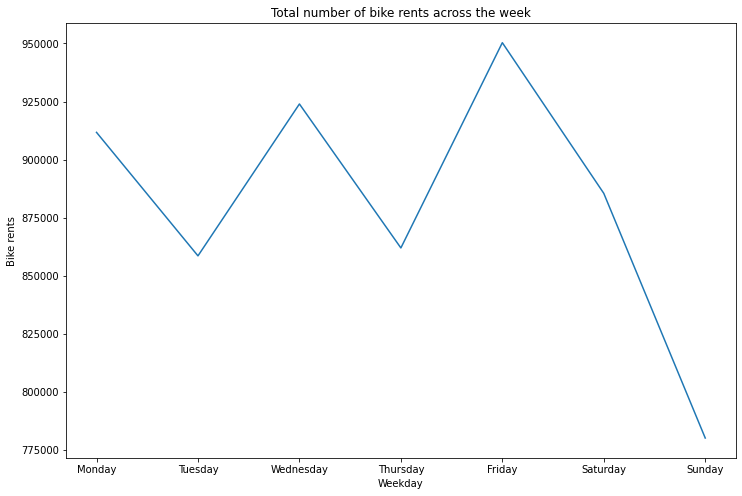

In [258]:
#grouping the data based on weekdays
rent_weekday_group = bikes_df[['WeekDayEncoding','RentedBikeCount']].groupby(['WeekDayEncoding'], sort=True).sum().reset_index()

plt.figure(figsize=(12,8))
plt.plot(rent_weekday_group['WeekDayEncoding'], rent_weekday_group['RentedBikeCount'])
plt.xticks(range(1,8), labels=mapping_dictDay)
plt.xlabel('Weekday')
plt.ylabel('Bike rents')
plt.title('Total number of bike rents across the week')
plt.show()

With a relatively good understanding of the data at hand, we may proceed to analyze data correlations.

## DATA CORRELATIONS

Let us start by checking the linear correlation between variables using the Pearson Correlation Coefficient.

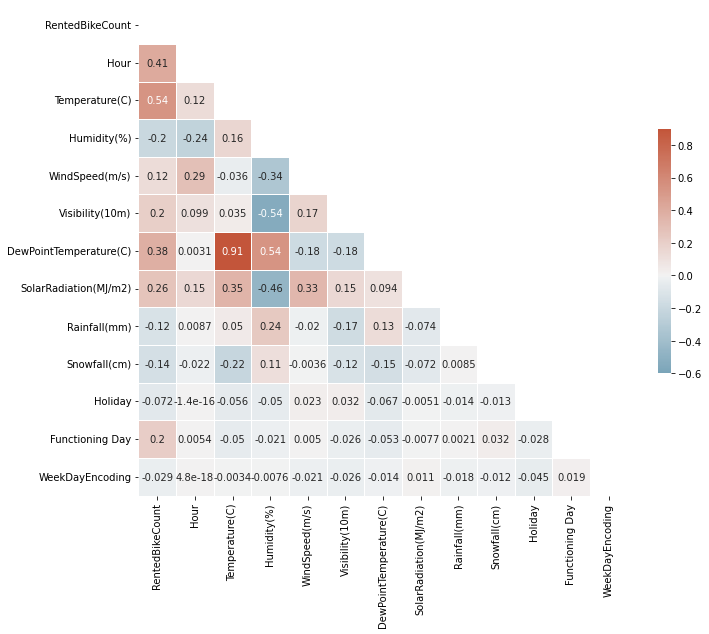

In [259]:
bikes_corr = bikes_df.corr()
#obscuring the upper-right half of the heatmap
mask = np.triu(np.ones_like(bikes_corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(bikes_corr, mask=mask, cmap=cmap, vmax=.9, vmin=-.6, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

Rented bike counts display positive linear correlation towards Hour, Temperature and Dew Point Temperature features.
Dew Point Temperature appears to be very closely correlated with Temperature.
Humidity appears to be negatively correlated with Visibility and Solar Radiation, while being positively correlated with Dew Point Temperature.

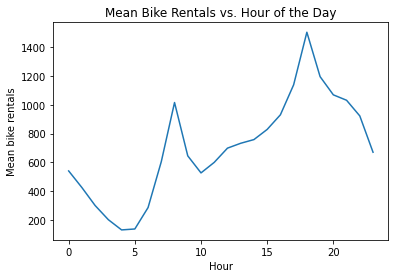

In [260]:
#checking the relationship between mean rented bike counts and hour of the day
grouping = bikes_df[['Hour','RentedBikeCount']].groupby(['Hour']).mean().reset_index()
plt.plot(grouping['Hour'], grouping['RentedBikeCount'])
plt.title('Mean Bike Rentals vs. Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Mean bike rentals')
plt.show()

Visualizing data correlation through scatter plots.

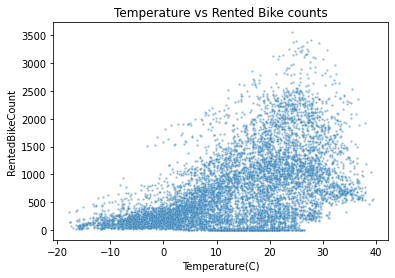

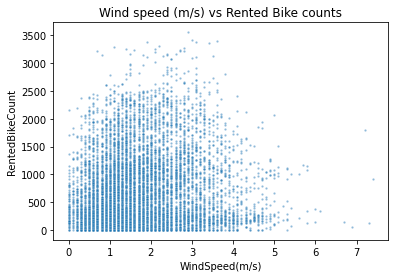

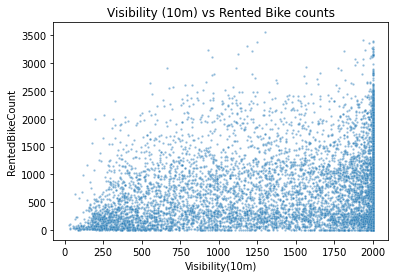

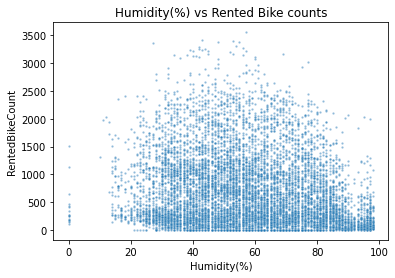

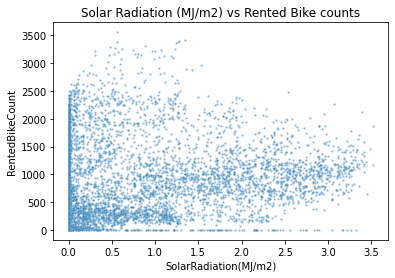

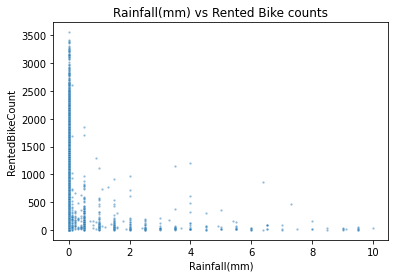

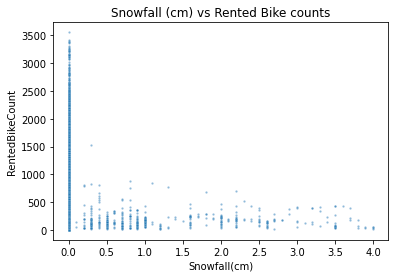

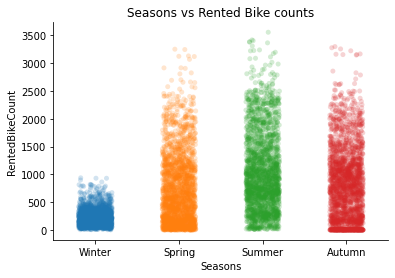

<Figure size 432x288 with 0 Axes>

In [261]:
sns.scatterplot(x=bikes_df['Temperature(C)'], y=bikes_df['RentedBikeCount'], s = 5, alpha=0.5)
plt.title('Temperature vs Rented Bike counts')
plt.show()
plt.clf()

sns.scatterplot(x=bikes_df['WindSpeed(m/s)'], y=bikes_df['RentedBikeCount'], s = 5, alpha=0.5)
plt.title('Wind speed (m/s) vs Rented Bike counts')
plt.show()
plt.clf()

sns.scatterplot(x=bikes_df['Visibility(10m)'], y=bikes_df['RentedBikeCount'], s = 5, alpha=0.5)
plt.title('Visibility (10m) vs Rented Bike counts')
plt.show()
plt.clf()

sns.scatterplot(x=bikes_df['Humidity(%)'], y=bikes_df['RentedBikeCount'], s = 5, alpha=0.5)
plt.title('Humidity(%) vs Rented Bike counts')
plt.show()
plt.clf()

sns.scatterplot(x=bikes_df['SolarRadiation(MJ/m2)'], y=bikes_df['RentedBikeCount'], s = 5, alpha=0.5)
plt.title('Solar Radiation (MJ/m2) vs Rented Bike counts')
plt.show()
plt.clf()

sns.scatterplot(x=bikes_df['Rainfall(mm)'][bikes_df['Rainfall(mm)'] <= 10], y=bikes_df['RentedBikeCount'], s = 5, alpha=0.5)
plt.title('Rainfall(mm) vs Rented Bike counts')
plt.show()
plt.clf()

sns.scatterplot(x=bikes_df['Snowfall(cm)'][bikes_df['Snowfall(cm)'] <= 4], y=bikes_df['RentedBikeCount'], s = 5, alpha=0.5)
plt.title('Snowfall (cm) vs Rented Bike counts')
plt.show()
plt.clf()

sns.stripplot(x='Seasons', y='RentedBikeCount', data=bikes_df, jitter=0.2, alpha=0.2)
sns.despine()
plt.title('Seasons vs Rented Bike counts')
plt.show()
plt.clf()


Based on the correlation matrix and the scatter plots, it seems the linear relationship between the rented bike counts and other variables is poor to moderate. This potentially violates the first assumption of linear regression model.

# Machine Learning

## Feature Engineering

In [262]:
#creating a copy of the DataFrame for further processing with only Functioning Days taken into consideration
bikes_df_testing = bikes_df[bikes_df['Functioning Day'] == True]

#creating one-hot-encoded data for categorical data
season_ohe = pd.get_dummies(bikes_df_testing.Seasons, drop_first=True)
weekday_ohe = pd.get_dummies(bikes_df_testing.WeekDay, drop_first=True)
bikes_df_testing = bikes_df_testing.join([season_ohe, weekday_ohe])

#using LabelEncoder for Month features to avoid multiplication of features
le = LabelEncoder()
bikes_df_testing['Month'] = le.fit_transform(bikes_df_testing['Month'])
#bikes_df_testing['Holiday'] = le.fit_transform(bikes_df_testing['Holiday'])
#checking columns
print(bikes_df_testing.columns)




Index(['Date', 'RentedBikeCount', 'Hour', 'Temperature(C)', 'Humidity(%)',
       'WindSpeed(m/s)', 'Visibility(10m)', 'DewPointTemperature(C)',
       'SolarRadiation(MJ/m2)', 'Rainfall(mm)', 'Snowfall(cm)', 'Seasons',
       'Holiday', 'Functioning Day', 'Month', 'WeekDay', 'WeekDayEncoding',
       'Spring', 'Summer', 'Winter', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')


In [263]:
#removing obsolete features
X = bikes_df_testing.drop(columns = ['RentedBikeCount', 'Date','WeekDay','WeekDayEncoding', 'Seasons'])
#selecting target
Y = bikes_df_testing['RentedBikeCount']
#making sure all features are numerical
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Hour                    8465 non-null   int64  
 1   Temperature(C)          8465 non-null   float64
 2   Humidity(%)             8465 non-null   int64  
 3   WindSpeed(m/s)          8465 non-null   float64
 4   Visibility(10m)         8465 non-null   int64  
 5   DewPointTemperature(C)  8465 non-null   float64
 6   SolarRadiation(MJ/m2)   8465 non-null   float64
 7   Rainfall(mm)            8465 non-null   float64
 8   Snowfall(cm)            8465 non-null   float64
 9   Holiday                 8465 non-null   int64  
 10  Functioning Day         8465 non-null   int64  
 11  Month                   8465 non-null   int32  
 12  Spring                  8465 non-null   uint8  
 13  Summer                  8465 non-null   uint8  
 14  Winter                  8465 non-null   

To select features for our model, we are using the Backward Stepwise Regression to evaluate each feature.

In [264]:
best_features = []

def backward_regression(X, Y, initial_list=[], threshold_out=0.05, verbose=True):
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(Y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() 
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"worst_feature : {worst_feature}, {worst_pval} ")
        if not changed:
            break
    best_features.append(included)
    print(f"\nSelected Features:\n{best_features[0]}")


# Application of the backward regression function on our data
backward_regression(X, Y)

worst_feature : Summer, 0.9942288573487192 
worst_feature : Wednesday, 0.66106884649523 
worst_feature : Spring, 0.5923597931369756 
worst_feature : DewPointTemperature(C), 0.2545581289534731 
worst_feature : Visibility(10m), 0.21200733065502494 
worst_feature : Tuesday, 0.07768699825553273 
worst_feature : Thursday, 0.15123654052851732 

Selected Features:
['Hour', 'Temperature(C)', 'Humidity(%)', 'WindSpeed(m/s)', 'SolarRadiation(MJ/m2)', 'Rainfall(mm)', 'Snowfall(cm)', 'Holiday', 'Functioning Day', 'Month', 'Winter', 'Monday', 'Saturday', 'Sunday']


In [265]:
#selecting features based on OLS method results with p value of 0.05
X = X[best_features[0]]

In [266]:
#normalizing features using MinMaxScaler
features = X
scaler = MinMaxScaler()
scaled = scaler.fit(features)
X = scaled.transform(features)
X = pd.DataFrame(X, columns=features.columns)

## Linear Regression Model


In [267]:
#creating train ,test and validation sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8, test_size = 0.2, random_state=6)
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 0.8, test_size = 0.2, random_state=4)
print(f'Size of the train set: {len(x_train)}')
print(f'Size of the test set: {len(x_test)}')
# print(f'Size of the validation set: {len(x_val)}')

Size of the train set: 6772
Size of the test set: 1693


C:\Users\Rogo\miniconda3\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Rogo\miniconda3\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


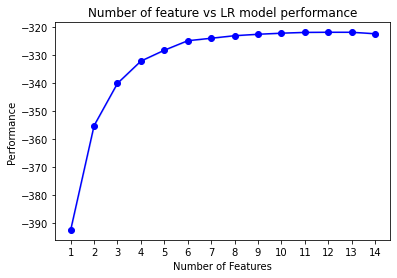

In [268]:
#determining the best number of features for linear regression
lr = LinearRegression()
sfs = SFS(lr,
          k_features=1,
          forward=False,
          floating=True,
          scoring='neg_mean_absolute_error',
          cv=0)
sfs.fit(x_train, y_train)

plot_sfs(sfs.get_metric_dict())
plt.title('Number of feature vs LR model performance')
plt.show()

In [269]:
scores = sfs.get_metric_dict()
no_of_features = 0
current_score = 0
for i in scores:
    if current_score == 0:
        current_score = scores[i]['cv_scores']
    elif scores[i]['cv_scores'] > current_score:
        current_score = scores[i]['cv_scores']
        no_of_features = i
print(current_score)
no_of_features

[-321.90410709]


13

In [270]:
sfs = SFS(lr,
          k_features=no_of_features,
          forward=False,
          floating=True,
          scoring='neg_mean_absolute_error',
          cv=5)
sfs.fit(x_train, y_train)

# Print the chosen feature names
print(sfs.subsets_[no_of_features]['feature_names'])


('Hour', 'Temperature(C)', 'Humidity(%)', 'WindSpeed(m/s)', 'SolarRadiation(MJ/m2)', 'Rainfall(mm)', 'Snowfall(cm)', 'Holiday', 'Functioning Day', 'Month', 'Winter', 'Monday', 'Sunday')


In [271]:
#selecting features for LR
x_train_LR = x_train[list(sfs.subsets_[14]['feature_names'])]
x_test_LR = x_test[list(sfs.subsets_[14]['feature_names'])]

In [272]:
#searching for the best alpha paramater for Lasso regularization
alpha_array = np.logspace(-1, 2, 100)
tuned_parameters = [{'alpha': alpha_array}]
model = GridSearchCV(estimator = Lasso(max_iter=2000), param_grid = tuned_parameters, scoring = 'neg_mean_absolute_error', cv = 5, return_train_score = True)
model.fit(x_train_LR, y_train)
test_scores = model.cv_results_['mean_test_score']
train_scores = model.cv_results_['mean_train_score']
lasso_best_alpha = model.best_params_['alpha']

print(model.best_params_, model.best_score_)

{'alpha': 0.32745491628777285} -323.1699963901228


In [273]:
lasso = Lasso(alpha = lasso_best_alpha)
lasso.fit(x_train_LR, y_train)

l1_pred_train = lasso.predict(x_train_LR)
l1_mse_train = np.sqrt(np.mean((l1_pred_train - y_train)**2))
print("Lasso (L1) Training Error: ", l1_mse_train)

# 2. Calculate testing error
l1_pred_test = lasso.predict(x_test_LR)
l1_mse_test = np.sqrt(np.mean((l1_pred_test - y_test)**2))
print(l1_mse_test)
print(lasso.score(x_test_LR, y_test))

Lasso (L1) Training Error:  428.26224354036685
432.3564896402466
0.5549623343601002


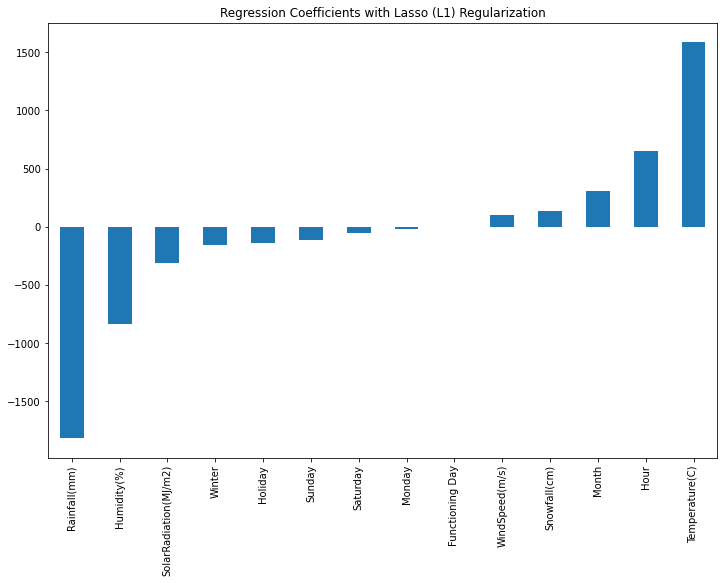

In [274]:
predictors = x_train_LR.columns
coef = pd.Series(lasso.coef_,predictors).sort_values()
plt.figure(figsize = (12,8))
coef.plot(kind='bar', title='Regression Coefficients with Lasso (L1) Regularization')
plt.show()

As mentioned before, the linear relationship between the target variable and predictor variables is not very strong, which already violates the first assumption of the linear regression and may explain the poor scores of the linear regression model.

## Decision Tree 

In [275]:
# DT_X = X[best_features[0]]
# DT_Y = bikes_df_testing['RentedBikeCount']
# x_train, x_test, y_train, y_test = train_test_split(DT_X, DT_Y, train_size = 0.8, test_size = 0.2, random_state=6)

In [276]:
#hyperparameter tuning of max_depth, ccp_array and min_samples paramters for the Decision Tree
max_depth_array = range(5,25)
ccp_array = np.logspace(-4,2,10)
min_samples_array=range(10,100, 10)
tuned_parameters = [{'max_depth': max_depth_array, 'ccp_alpha': ccp_array, 'min_samples_leaf':min_samples_array}]
model = GridSearchCV(estimator = DecisionTreeRegressor(), param_grid = tuned_parameters, scoring = 'neg_mean_absolute_error', cv = 5, return_train_score = False)
model.fit(x_train, y_train)

DT_best_depth = model.best_params_['max_depth']
DT_best_ccp = model.best_params_['ccp_alpha']
DT_best_minsamp = model.best_params_['min_samples_leaf']
print(model.best_params_, model.best_score_)

{'ccp_alpha': 0.21544346900318823, 'max_depth': 15, 'min_samples_leaf': 10} -151.33392123453095


In [277]:
#training the actual model
dt = DecisionTreeRegressor(min_samples_leaf = DT_best_minsamp, max_depth = DT_best_depth, ccp_alpha = DT_best_ccp)
dt.fit(x_train, y_train)

dt_pred_train = dt.predict(x_train)
dt_train_score = np.sqrt(np.mean((dt_pred_train - y_train)**2))
print("DT Training Error: ", dt_train_score)


dt_pred_test = dt.predict(x_test)
dt_test_score = np.sqrt(np.mean((dt_pred_test - y_test)**2))
print("DT Testing Error: ", dt_test_score)

print("Model train score: ", dt.score(x_train, y_train))
print("Model test score: ", dt.score(x_test, y_test))

DT Training Error:  179.95754647430996
DT Testing Error:  244.88977943919136
Model train score:  0.9211440768927044
Model test score:  0.8572243569426274


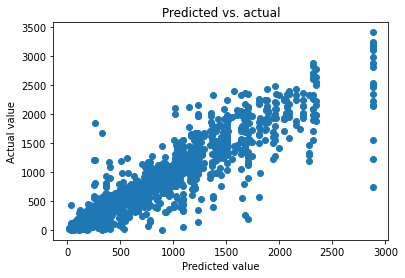

In [182]:
plt.scatter(dt_pred_test, y_test)
plt.title('Predicted vs. actual')
plt.xlabel('Predicted value')
plt.ylabel('Actual value')
plt.show()

# 